In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

# Parameters
batch_size = 64
learning_rate = 0.02
num_epoches = 5
gamma = 0.7
log_interval = 200

In [2]:
# Load dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
# Reference :
# https://github.com/pytorch/examples/blob/main/mnist/main.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

device_name = "cuda" if torch.cuda.is_available() else "cpu"
print(f"PyTorch will run on {device_name} device")
device = torch.device(device_name)
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)

PyTorch will run on cuda device


In [4]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

        train_loss += loss.item()

    return train_loss * train_loader.batch_size / len(train_loader.dataset)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return test_loss

In [5]:
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
train_losses = []
test_losses = []
for epoch in range(1, num_epoches + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss = test(model, device, test_loader)
    scheduler.step()

    train_losses.append(train_loss)
    test_losses.append(test_loss)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307993
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.882122
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.361992
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.292154
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.282455

Test set: Average loss: 0.2504, Accuracy: 9293/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.525784
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.339000
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.385175
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.210137
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.277513

Test set: Average loss: 0.1768, Accuracy: 9475/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.204720
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.297781
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.316516
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.198827
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.219763

Test set: Average loss: 0.1459, Accuracy: 9564/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.312407
Train Epoch: 4 [12800/60000 (21%)]	Lo

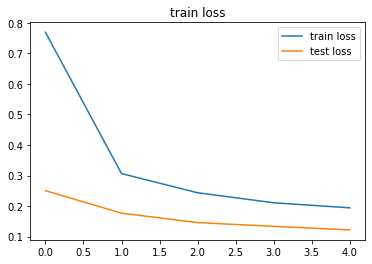

In [7]:
plt.figure()
plt.title('train loss')
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend([r'train loss', r'test loss'])
plt.show()